# GLOVe-LSA-SVM
- Uses LSA to capture latent features
- Uses SVM to find optimal hyperplane of separation

In [1]:
## IMPORTS
# GLOVE Embeddings
import spacy

# LSA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

# SVM
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid, StratifiedKFold
import scipy.stats as stats
from joblib import parallel_backend

# Preprocessing
import csv
import chardet
import numpy as np
import re
import pandas as pd
import demoji
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import json

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/walnuts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the dataset / read csv
# MAKE SURE CSV IS IN UTF-8 (if tweets have emojis)

## Testing if csv can open (Use for troubleshooting)
# with open('Eng_Tweets.csv') as csv_file:
#   csvFile = csv.reader(csv_file, delimiter=',')
#   for row in csv_file:
#     print(row)

## RUN PARAMETERS
LANG = 1  # 1 = English | 2 = Tagalog | 3 = TagLish | 4 = Mixed
DO_GRIDSEARCH = False
manual_params = { # If not using GridSearchCV
    'probability': True,
    'C': 1,
    'kernel': 'linear',
    'class_weight': None,
    'random_state': 42
}

pd.set_option('display.max_colwidth', None)

# Assign the CSV path based on LANG value
if LANG == 1:
    csv_path = 'Eng_Tweets.csv'
elif LANG == 2:
    csv_path = 'Tag_Tweets.csv'
elif LANG == 3:
    csv_path = 'TagLish_Tweets.csv'
elif LANG == 4:
    csv_path = 'Mixed_Tweets.csv'
else:
    raise ValueError("Invalid value for LANG. Must be 1, 2, 3, or 4.")


df = pd.read_csv(csv_path)
print("total rows: " + str(len(df)))
df.head() ## head won't show emojis unless using print function

total rows: 2338


,Username,Tweet,Date posted,Label
0,@fudaishii,i'm genuinely going to attempt tonight i can't do this anymore i can't handle all this stress i wish i was never born bro,9/11/24,1
1,@yourdystiny,"Becoming less reactive is a huge part of growth & decreasing stress. If you let everything get you worked up, you’ll damage your mind, body & spirit.",9/8/24,0
2,@ocenhxu,me ??? tired ??? stressed ??? exhausted ??? i wanna cry ??? yes.,9/8/24,1
3,@ifeelgoodto,"skipping meals, irregular sleeping habits, overthinking, stress, tired and drained. that's me, that's my everyday life",9/10/24,1
4,@ysuckme,"you deserve to be happy. not confused, not hurt, not stressed, just happy.",9/8/24,0


## Preprocessing
- Remove mentions (@)
- Remove hashtags (#)
- Remove URLs
- Replace emojis with textual description (Using demoji)
- Remove stop words

In [3]:
### PREPROCESSING STEPS (FOR TAGALOG)
with open('tl_stopwords.json', 'r') as f:
    tagalog_stop_words = json.load(f)

# Preprocessing functions
def clean_text_tl(text):
    # Remove mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Replace emoji with textual descriptions
    text = demoji.replace_with_desc(text)
    text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text)  # Add spaces around the shortcode
    text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
    text = text.strip()
    return text

def remove_stopwords_tl(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in tagalog_stop_words]
    return ' '.join(filtered_words)

In [4]:
### PREPROCESSING STEPS
def clean_text(text):
  # Remove mentions
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  # Remove hashtags
  text = re.sub(r'#\w+', '', text)
  # Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  # Replace emoji with textual descriptions
  text = demoji.replace_with_desc(text)
  text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text) # Add spaces around the shortcode
  text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
  text = text.strip()
  return text

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

df = df.dropna() # Get rid of NaN rows

In [5]:
## Execute preprocessing
df = df.dropna()  # Get rid of NaN rows

if LANG == 1:
    print("EXECUTING ENGLISH TWEET CLEANING")
    df['Tweet'] = df['Tweet'].apply(clean_text)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords)
elif LANG == 2:
    print("EXECUTING TAGALOG TWEET CLEANING")
    df['Tweet'] = df['Tweet'].apply(clean_text_tl)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords_tl)
else:
    print("EXECUTING BOTH ENGLISH AND TAGALOG TWEET CLEANING")
    df['Tweet'] = df['Tweet'].apply(clean_text_tl)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords_tl)
    df['Tweet'] = df['Tweet'].apply(clean_text)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords)
    

df.head()

EXECUTING ENGLISH TWEET CLEANING


,Username,Tweet,Date posted,Label
0,@fudaishii,i'm genuinely going attempt tonight can't anymore can't handle stress wish never born bro,9/11/24,1
1,@yourdystiny,"Becoming less reactive huge part growth & decreasing stress. let everything get worked up, you’ll damage mind, body & spirit.",9/8/24,0
2,@ocenhxu,??? tired ??? stressed ??? exhausted ??? wanna cry ??? yes.,9/8/24,1
3,@ifeelgoodto,"skipping meals, irregular sleeping habits, overthinking, stress, tired drained. that's me, that's everyday life",9/10/24,1
4,@ysuckme,"deserve happy. confused, hurt, stressed, happy.",9/8/24,0


In [6]:
df['Label'].value_counts()

Label
0    1897
1     441
Name: count, dtype: int64

## GloVe Embeddings
- Make sure to run "python -m spacy download en_core_web_md"
- GloVe embeddings are then averaged and standardized
- Train-Test-Validation split = 70% - 20% - 10%
- Uses undersampling to balance the training set

In [7]:
nlp = spacy.load("en_core_web_md", disable=["tagger", "parser", "ner"]) # disable non word-embedding parts of spacy

# Create an empty list to store the embeddings
embeddings = []

# Iterate through the DataFrame
for index, row in df.iterrows():
    tweet = row['Tweet']
    doc = nlp(tweet)

    # Get the embeddings for each token and store them
    tweet_embeddings = [token.vector for token in doc]
    embeddings.append(tweet_embeddings)

# Add the embeddings to the DataFrame as a new column
df['embeddings'] = embeddings

/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check

In [8]:
# Function to average embeddings for a tweet
def average_embeddings(embeddings_list):
    if embeddings_list:
        return np.mean(embeddings_list, axis=0)
    else:
        return np.zeros(300)  # 300 = embedding dimension

In [9]:
# Function to split the dataset into train, validation, and test
def split_data(df, train_size=0.7, val_size=0.1, test_size=0.2):
    # 70% into training 30% into validation + testing 
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=42)
    
    # 30% splits 10% into validation and 20% into testing
    val_df, test_df = train_test_split(temp_df, train_size=val_size / (val_size + test_size), random_state=42)
    
    return train_df, val_df, test_df

In [10]:
# Average the sentence embedding into a single entry
df['avg_embedding'] = df['embeddings'].apply(average_embeddings)

# Split the dataset
train_df, val_df, test_df = split_data(df)

X_train = np.array(train_df['avg_embedding'].to_list())
y_train = train_df['Label']
X_val = np.array(val_df['avg_embedding'].to_list())
y_val = val_df['Label']
X_test = np.array(test_df['avg_embedding'].to_list())
y_test = test_df['Label']

# UNDERSAMPLING
# undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# OVERSAMPLING
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Class distribution after undersampling:\n{pd.Series(y_train_resampled).value_counts()}")

Class distribution after undersampling:
Label
0    1313
1    1313
Name: count, dtype: int64


In [11]:
np.set_printoptions(linewidth=200)  # Increase linewidth to fit more in a row
print("Averaged Glove embeddings:")
print(df.loc[0, 'avg_embedding'])

Averaged Glove embeddings:
[-7.06352353e-01  1.78621799e-01 -3.16151351e-01 -1.89257994e-01 -7.80870616e-02  1.04641758e-01  7.14401901e-02 -3.07269424e-01  9.94581133e-02  2.00123882e+00 -1.39243469e-01 -2.22805887e-02
  1.84803531e-02  9.14731324e-02 -2.67876506e-01 -5.59489392e-02 -2.13040560e-02  3.90589446e-01 -7.35513493e-02  1.34178251e-01  6.18738718e-02  8.06470576e-04  1.46613076e-01 -2.00203359e-01
 -1.34678828e-02 -1.16536885e-01 -2.37409249e-01 -2.23987728e-01  1.49625123e-01 -1.40616357e-01 -1.26576066e-01  1.68735459e-01 -1.28252015e-01 -5.17503545e-02  5.42461723e-02  3.50671679e-01
  1.52729124e-01  5.38464040e-02 -1.15303636e-01  6.99241236e-02 -1.50172427e-01 -7.58571178e-02 -1.72877893e-01  1.81052074e-01  1.31359652e-01  7.48350343e-04  1.12650199e-02  2.11694449e-01
 -1.29441902e-01 -1.80861801e-02 -1.87942132e-01  2.11081207e-01  8.10847133e-02  2.58171987e-02 -1.96084697e-02  1.05538554e-01 -3.88949215e-02 -3.83855961e-02  9.10718814e-02 -3.30785960e-02
 -1.0855

## LSA (Latent Semantic Analysis)
- Also uses standard scaler for standardization of values

In [12]:
# Apply LSA (Latent Semantic Analysis) for dimensionality reduction
lsa = TruncatedSVD(n_components=100, random_state=42) 

X_train_lsa = lsa.fit_transform(X_train_resampled)
X_val_lsa = lsa.transform(X_val)
X_test_lsa = lsa.transform(X_test)

# Standardization (scaling)
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_lsa)
X_val = scaler.transform(X_val_lsa)
X_test = scaler.transform(X_test_lsa)

# Assign the CSV path based on LANG value
if LANG == 1:
    path = 'English'
elif LANG == 2:
    path = 'Tagalog'
elif LANG == 3:
    path = 'Taglish'
elif LANG == 4:
    path = 'Mixed'

def is_fitted_scaler(scaler):
    # Check if the 'mean_' and 'scale_' attributes exist (these are computed during fit)
    return hasattr(scaler, 'mean_') and hasattr(scaler, 'scale_')

def is_fitted_lsa(lsa):
    # Check if the 'components_' and 'singular_values_' attributes exist (these are computed during fit)
    return hasattr(lsa, 'components_') and hasattr(lsa, 'singular_values_')

# Check if the scaler is fitted
if is_fitted_scaler(scaler):
    print("Scaler is fitted!")
else:
    print("Scaler is not fitted!")

# Check if the LSA is fitted
if is_fitted_lsa(lsa):
    print("LSA is fitted!")
else:
    print("LSA is not fitted!")
    
os.makedirs('saved_models/' + path, exist_ok=True)
os.makedirs('saved_models/Scalers/', exist_ok=True)
os.makedirs('saved_models/LSA/', exist_ok=True)

scaler_path = "saved_models/Scalers/GLSScaler_" + path + ".pkl"
with open(scaler_path, 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

lsa_path = "saved_models/LSA/LSA_" + path + ".pkl"
with open(lsa_path, 'wb') as lsa_file:
    pickle.dump(lsa, lsa_file)

Scaler is fitted!
LSA is fitted!


In [13]:
print("Length of training set after LSA dimensionality reduction: ", len(X_train_lsa))
print(X_train_lsa)

Length of training set after LSA dimensionality reduction:  2626
[[ 1.2803038e+00 -2.1580350e-01  3.4483166e+00 ... -1.0969957e-03 -3.1374812e-02 -5.6506321e-03]
 [ 3.3887670e+00  6.5551662e-01 -8.1608869e-02 ... -6.6964149e-02  3.1116871e-02 -4.5547206e-02]
 [ 2.8254807e+00  6.3296700e-01  2.9627228e-01 ... -6.3495822e-02  4.0021505e-02  8.9607434e-03]
 ...
 [ 3.6114509e+00 -1.8300958e-01  4.2363641e-01 ... -3.6542051e-02 -2.0949699e-02 -2.7029268e-02]
 [ 3.6546774e+00  7.0314050e-01 -1.3244900e-01 ...  6.7724980e-02  1.2117056e-02  2.6746966e-02]
 [ 3.6339200e+00 -4.2531353e-01 -5.9299237e-01 ...  6.6613898e-02 -3.7077531e-02 -4.5084849e-02]]


## SVM (Support Vector Machine)

In [14]:
# Modify param_grid for linear kernel
if DO_GRIDSEARCH:
    param_grid_linear = {
        'C': [100],
        'kernel': ['linear'],  # Only linear kernel
        'class_weight': [None, 'balanced'],  # Class weight
    }
    
    # Stratified K Fold
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize the SVC model
    svc = SVC(probability=True)
    
    # Define the GridSearchCV object with StratifiedKFold
    grid_search_linear = GridSearchCV(
        estimator=svc,
        param_grid=param_grid_linear,
        cv=stratified_kfold,
        n_jobs=-1,
        verbose=3,
        scoring='accuracy'
    )
    
    # Fit the grid search to the training data
    with parallel_backend('multiprocessing'):
        grid_search_linear.fit(X_train_final, y_train_resampled)
    
    # Get the best parameters and best score for linear kernel
    best_params_linear = grid_search_linear.best_params_
    best_score_linear = grid_search_linear.best_score_
    
    # Print the results for linear kernel
    print(f"Best parameters for linear kernel: {best_params_linear}")
    print(f"Best cross-validation Accuracy for linear kernel: {best_score_linear:.4f}")
else:
    print("Skipped GridSearchCV")

Skipped GridSearchCV


In [15]:
# Using the best parameters from grid search or random search
if DO_GRIDSEARCH:
    best_model = grid_search.best_estimator_  # or 
    # best_model = random_search.best_estimator_
else:
    # Manual plug and fit
    best_model = SVC(**manual_params)
    best_model.fit(X_train_final, y_train_resampled)

if not hasattr(best_model, 'coef_'):
    raise ValueError("The model is not fitted yet. Please fit the model before using it.")
else:
    print("Model is properly loaded and fitted.")

# save the model
model_path = 'saved_models/' + path + '/Glove-LSA-SVM_' + path + '.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print("Model saved successfully!")

# Final evaluation on the test set
y_pred_test = best_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy_test}")

Model is properly loaded and fitted.
Model saved successfully!
Test Accuracy: 0.7713675213675214


Validation Accuracy: 0.7564102564102564
Validation Precision: 0.3382352941176471
Validation Recall: 0.6571428571428571
Validation F1 Score: 0.44660194174757284
Validation Balanced Accuracy: 0.7155061019382627
Validation Confusion Matrix: 
[[154  45]
 [ 12  23]]
Test Accuracy: 0.7713675213675214
Test Precision: 0.4189189189189189
Test Recall: 0.7469879518072289
Test F1 Score: 0.5367965367965368
Test Balanced Accuracy: 0.7618056642153028
Test Confusion Matrix: 
[[299  86]
 [ 21  62]]
Test ROC AUC: 0.8186199342825848


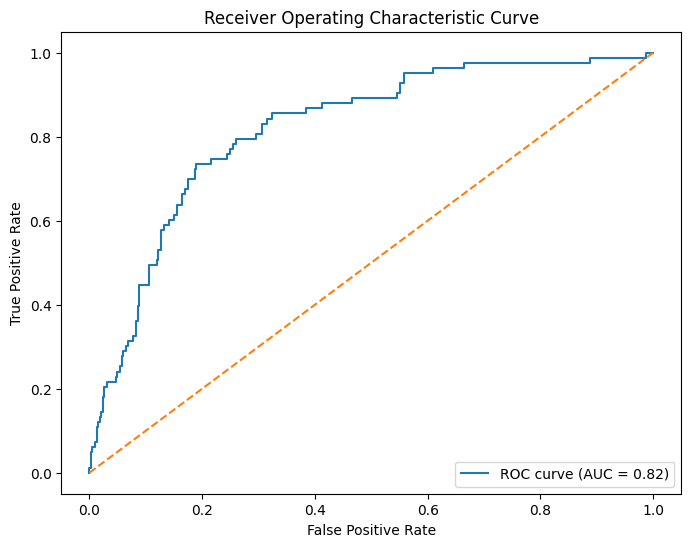

In [16]:
# Evaluation on validation set
y_pred_val = best_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
balanced_acc_val = balanced_accuracy_score(y_val, y_pred_val)  # Add balanced accuracy
conf_matrix_val = confusion_matrix(y_val, y_pred_val)

print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1 Score: {f1_val}")
print(f"Validation Balanced Accuracy: {balanced_acc_val}")  # Print balanced accuracy
print(f"Validation Confusion Matrix: \n{conf_matrix_val}")

# Final evaluation on test set
y_pred_test = best_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
balanced_acc_test = balanced_accuracy_score(y_test, y_pred_test)  # Add balanced accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test Balanced Accuracy: {balanced_acc_test}")  # Print balanced accuracy
print(f"Test Confusion Matrix: \n{conf_matrix_test}")

# Compute ROC AUC
y_prob_test = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_prob_test)
print(f"Test ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

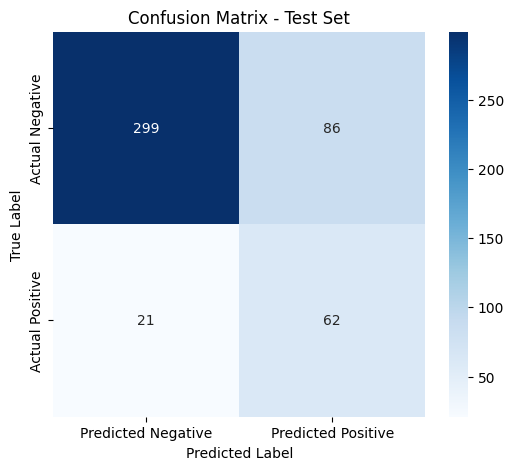

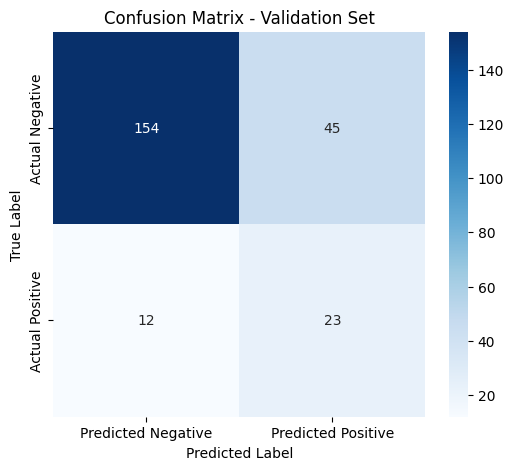

In [17]:
# Plot confusion matrix for test set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [18]:
# Using StratifiedKFold for cross-validation
# stratified_cv = StratifiedKFold(n_splits=5)

# train_sizes, train_scores, test_scores = learning_curve(
#     best_model, X_train_final, y_train_resampled, cv=stratified_cv,  # Use StratifiedKFold
#     scoring='accuracy', 
#     train_sizes=np.linspace(0.1, 1.0, 10), 
#     n_jobs=-1
# )

# # Calculate the mean and standard deviation of train and test scores
# train_scores_mean = train_scores.mean(axis=1)
# train_scores_std = train_scores.std(axis=1)
# test_scores_mean = test_scores.mean(axis=1)
# test_scores_std = test_scores.std(axis=1)

# # Print the final scores (for the largest training set size)
# print(f"Final Training Score: {train_scores_mean[-1]:.4f}")
# print(f"Final Cross-validation Score: {test_scores_mean[-1]:.4f}")

# # Plot the learning curve
# plt.figure(figsize=(8, 6))
# plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
# plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='green')

# # Fill the area between the curve and the axis to represent the standard deviation
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.2)

# # Add labels and title
# plt.xlabel('Training Set Size')
# plt.ylabel('Accuracy')
# plt.title('Learning Curve')
# plt.legend(loc='best')
# plt.grid(True)
# plt.show()

In [55]:
import pickle
import numpy as np
import spacy
import demoji
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords

# Load the pre-trained Spacy model
nlp = spacy.load("en_core_web_md", disable=["tagger", "parser", "ner"])

# Load stopwords
stop_words = set(stopwords.words('english'))

# Load the pre-trained model and scaler
model_path = "saved_models/English/Glove-LSA-SVM_English.pkl"
scaler_path = "saved_models/Scalers/GLSScaler_English.pkl"
lsa_model_path = "saved_models/LSA/LSA_English.pkl"

with open(model_path, 'rb') as model_file:
    model = pickle.load(model_file)

with open(scaler_path, 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)

with open(lsa_model_path, 'rb') as lsa_file:
    lsa = pickle.load(lsa_file)

# Define text preprocessing function
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = demoji.replace_with_desc(text)  # Replace emojis with text
    text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text)  # Add spaces around the shortcode
    text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
    text = text.strip()  # Remove leading/trailing spaces
    return text

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Function to extract embeddings from text
def get_avg_embedding(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    
    # Create embeddings for the clean text using the Spacy model
    doc = nlp(text)
    embeddings = [token.vector for token in doc]
    avg_embedding = np.mean(embeddings, axis=0) if embeddings else np.zeros(300)
    
    return avg_embedding

# Function to apply LSA transformation
def apply_lsa(embedding):
    embedding_lsa = lsa.transform([embedding])
    return embedding_lsa

# Function to predict the class of a given tweet
def predict_sentiment(tweet):
    # Preprocess the tweet and extract the embeddings
    avg_embedding = get_avg_embedding(tweet)
    
    # Apply LSA transformation
    avg_embedding_lsa = apply_lsa(avg_embedding)
    
    # Scale the embeddings using the saved scaler
    avg_embedding_scaled = scaler.transform(avg_embedding_lsa)

    # Make the prediction using the model
    prediction = model.predict_proba(avg_embedding_scaled)
    
    return prediction[0]

# Main function to interact with the user
if __name__ == "__main__":
    # tweet = input("Enter a tweet to predict sentiment: ")
    # prediction = predict_sentiment("i wanna die. carried a game of overwatch as junkrat. I kid you not other dps had 500 dmg 5 minutes into into the game, WHAT ARE YOU A MERCY?? In the end we lost and the moira that threw the game just said \"you aren't good enough\"")
    prediction1 = predict_sentiment("I just want to sleep and never wake up")
    prediction2 = predict_sentiment("")
    
    # Print the prediction
    print(f"Predicted sentiment: {prediction1}")
    print(f"Predicted sentiment: {prediction2}")


Predicted sentiment: [0.05443435 0.94556565]
Predicted sentiment: [0.42423548 0.57576452]


/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
